In [119]:
import lucem_illud_2020

import collections
import os
import os.path
import random
import re
import glob
import pandas as pd
import requests
import json
import math
import nltk
import wordcloud
import matplotlib.pyplot as plt

import sklearn
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition

import gensim

import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
import matplotlib.colors # For nice colours
import seaborn #Makes plots look nice, also heatmaps
import scipy as sp #for interp

In [ ]:
# example of how I created dataframes from the text that I collected

targetDir = '/Users/Leha/Desktop/Izvestia/Abby_Fine_Reader_Extracted_Text/1987_txt'
izvestiiaText = []
izvestiiaFileName = []
IzvestiiaYear = []
Izvestiiatype = []
t = "Communist"
year = "1987"


for file in (file for file in os.scandir(targetDir) if file.is_file() and not file.name.startswith('.')):
    with open(file.path, encoding="utf-8") as f:
        izvestiiaText.append(f.read())
    izvestiiaFileName.append(file.name)
    IzvestiiaYear.append(year)
    Izvestiiatype.append(t)

In [ ]:
izvestiia_df1987 = pandas.DataFrame({'text' : izvestiiaText, 'year':IzvestiiaYear, 'filename':izvestiiaFileName, 'type':Izvestiiatype})

In [ ]:
# example of creating a dataframe of all years from individual years
df = pd.concat([izvestiia_df1987, izvestiia_df1988, izvestiia_df1989, izvestiia_df1990, izvestiia_df1991, izvestiia_df1992, izvestiia_df1993, izvestiia_df1994])

In [8]:
# Final product:
df = pd.read_json('izvestiia_text.json')

In [9]:
df

,text,year,filename,type
0,ПРАВОВОЕ ВОСПИТАНИЕ МОЛОДЕЖИ\n\nЛЛДИН мз «Днем...,1984,1984 Issue 082 Page 1.txt,Communist
1,"ЗЕМЛЯ, ПЛАН И ЛЮДИ\n\nМЫ ЛЮБИМ говорить: земля...",1984,1984 Issue 082 Page 2.txt,Communist
2,В Президиумах Доеных Советов союзных республик...,1984,1984 Issue 082 Page 3.txt,Communist
3,по странам и континентам\n\nновости\n\n\t\t\t\...,1984,1984 Issue 082 Page 4.txt,Communist
4,Фотоатлас «Известий»\n\nВьетнам\n\nИзо дня в д...,1984,1984 Issue 082 Page 5.txt,Communist
...,...,...,...,...
1299,﻿№ 94 •\nИЗВЕСТИЯ\n22 мая 1997 года • 4^\nИрин...,1997,1997 Issue 94 May 22 Page 5.txt,Democratic
1300,﻿№ 94 •\nИЗВЕСТИЯ\nБОЛЬШИЕ\nОЗМОЖНОСТИ\nРОСТА\...,1997,1997 Issue 94 May 22 Page 6.txt,Democratic
1301,﻿БРОКЕРСКАЯ КОМПАНИЯ\nФЫОЧ1РСЫ и ОПЦИОНЫ на АК...,1997,1997 Issue 94 May 22 Page 7.txt,Democratic
1302,"﻿II • 22 мая 1997 г., четверг\nБИЗНЕС И ЭКОНОМ...",1997,1997 Issue 94 May 22 Page 8.txt,Democratic


In [10]:
df['category'] = [s == 'Communist' for s in df['type']]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [11]:
def text_cleaner(text):
    return re.sub('[^а-яА-Я\s.,?!]', '', text)

In [12]:
df['clean_text'] = df['text'].apply(lambda x: text_cleaner(x))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [13]:
def text_cleaner2(text):
    clean_text = text.replace("Росии", "России").replace("\n", "").replace("/t", "").replace("\t", "")
    return clean_text

In [14]:
df['clean_text2'] = df['clean_text'].apply(lambda x: text_cleaner2(x))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [15]:
import stanza

In [16]:
stanza.download('ru')

2020-06-10 22:46:31 INFO: Downloading default packages for language: ru (Russian)...
2020-06-10 22:46:33 INFO: File exists: /Users/Leha/stanza_resources/ru/default.zip.
2020-06-10 22:46:40 INFO: Finished downloading models and saved to /Users/Leha/stanza_resources.


In [17]:
def sen_token(word_list):
    sen = []
    doc = nlp(word_list)
    for sentence in doc.sentences:
            for token in sentence.tokens:
                sen.append(token.text)
    return sen

In [18]:
nlp = stanza.Pipeline('ru', processors = 'tokenize')

2020-06-10 22:49:38 INFO: Loading these models for language: ru (Russian):
| Processor | Package   |
-------------------------
| tokenize  | syntagrus |

2020-06-10 22:49:38 INFO: Use device: cpu
2020-06-10 22:49:38 INFO: Loading: tokenize
2020-06-10 22:49:38 INFO: Done loading processors!


In [ ]:
df['tokenized'] = df['clean_text2'].apply(lambda x: sen_token(x))

In [3]:
df = pd.read_json('izvestiia_sorted_lemmas.json')

In [22]:
df

,text,year,filename,type,category,clean_text,clean_text2,tokenized,lemmas,lemmas_string
0,ПРАВОВОЕ ВОСПИТАНИЕ МОЛОДЕЖИ\n\nЛЛДИН мз «Днем...,1984,1984 Issue 082 Page 1.txt,Communist,True,ПРАВОВОЕ ВОСПИТАНИЕ МОЛОДЕЖИ\n\nЛЛДИН мз Днем ...,ПРАВОВОЕ ВОСПИТАНИЕ МОЛОДЕЖИЛЛДИН мз Днем депу...,"[ПРАВОВОЕ, ВОСПИТАНИЕ, МОЛОДЕЖИЛЛДИН, мз, Днем...","[правовой, воспитание, молодежиллдин, мз, день...",правовой воспитание молодежиллдин мз день депу...
1,"ЗЕМЛЯ, ПЛАН И ЛЮДИ\n\nМЫ ЛЮБИМ говорить: земля...",1984,1984 Issue 082 Page 2.txt,Communist,True,ЗЕМЛЯ ПЛАН И ЛЮДИ\n\nМЫ ЛЮБИМ говорить земля\n...,ЗЕМЛЯ ПЛАН И ЛЮДИМЫ ЛЮБИМ говорить земля наше ...,"[ЗЕМЛЯ, ПЛАН, И, ЛЮДИМЫ, ЛЮБИМ, говорить, земл...","[земля, план, людимый, любить, говорить, земля...",земля план людимый любить говорить земля главн...
2,В Президиумах Доеных Советов союзных республик...,1984,1984 Issue 082 Page 3.txt,Communist,True,В Президиумах Доеных Советов союзных республик...,В Президиумах Доеных Советов союзных республик...,"[В, Президиумах, Доеных, Советов, союзных, рес...","[президиум, доеный, совет, союзный, республику...",президиум доеный совет союзный республикукраин...
3,по странам и континентам\n\nновости\n\n\t\t\t\...,1984,1984 Issue 082 Page 4.txt,Communist,True,по странам и континентам\n\nновости\n\n\t\t\t\...,по странам и континентамновостиЛАОСПУТЬ БОРЬБЫ...,"[по, странам, и, континентамновостиЛАОСПУТЬ, Б...","[страна, континентамновостилаоспуть, борьба, и...",страна континентамновостилаоспуть борьба ишвец...
4,Фотоатлас «Известий»\n\nВьетнам\n\nИзо дня в д...,1984,1984 Issue 082 Page 5.txt,Communist,True,Фотоатлас Известий\n\nВьетнам\n\nИзо дня в дан...,Фотоатлас ИзвестийВьетнамИзо дня в дань крепну...,"[Фотоатлас, ИзвестийВьетнамИзо, дня, в, дань, ...","[фотоатлас, известийтнийтнамиз, день, дань, кр...",фотоатлас известийтнийтнамиз день дань крепнут...
...,...,...,...,...,...,...,...,...,...,...
1299,﻿№ 94 •\nИЗВЕСТИЯ\n22 мая 1997 года • 4^\nИрин...,1997,1997 Issue 94 May 22 Page 5.txt,Democratic,False,\nИЗВЕСТИЯ\n мая года \nИрина СУВОРОВА Иль...,ИЗВЕСТИЯ мая года Ирина СУВОРОВА Илья ХАИТ...,"[ИЗВЕСТИЯ, мая, года, Ирина, СУВОРОВА, Илья, Х...","[известие, май, год, ирина, суворовый, илья, х...",известие май год ирина суворовый илья хаить ис...
1300,﻿№ 94 •\nИЗВЕСТИЯ\nБОЛЬШИЕ\nОЗМОЖНОСТИ\nРОСТА\...,1997,1997 Issue 94 May 22 Page 6.txt,Democratic,False,\nИЗВЕСТИЯ\nБОЛЬШИЕ\nОЗМОЖНОСТИ\nРОСТА\nДЛЯ ...,ИЗВЕСТИЯБОЛЬШИЕОЗМОЖНОСТИРОСТАДЛЯ ЗАИНТЕРЕСО...,"[ИЗВЕСТИЯБОЛЬШИЕОЗМОЖНОСТИРОСТАДЛЯ, ЗАИНТЕРЕСО...","[известиябольшие-зможташтадтадля, заинтересова...",известиябольшие-зможташтадтадля заинтересованн...
1301,﻿БРОКЕРСКАЯ КОМПАНИЯ\nФЫОЧ1РСЫ и ОПЦИОНЫ на АК...,1997,1997 Issue 94 May 22 Page 7.txt,Democratic,False,БРОКЕРСКАЯ КОМПАНИЯ\nФЫОЧРСЫ и ОПЦИОНЫ на АКЦИ...,БРОКЕРСКАЯ КОМПАНИЯФЫОЧРСЫ и ОПЦИОНЫ на АКЦИИ ...,"[БРОКЕРСКАЯ, КОМПАНИЯФЫОЧРСЫ, и, ОПЦИОНЫ, на, ...","[брокерский, компанияфыочрс, опцион, акция, гк...",брокерский компанияфыочрс опцион акция гко дол...
1302,"﻿II • 22 мая 1997 г., четверг\nБИЗНЕС И ЭКОНОМ...",1997,1997 Issue 94 May 22 Page 8.txt,Democratic,False,мая г четверг\nБИЗНЕС И ЭКОНОМИКА\nФИНАНСО...,мая г четвергБИЗНЕС И ЭКОНОМИКАФИНАНСОВЫЕ ...,"[мая, г, четвергБИЗНЕС, И, ЭКОНОМИКАФИНАНСОВЫЕ...","[май, год, четвергбизнес, экономикафинансовый,...",май год четвергбизнес экономикафинансовый изве...


In [4]:
countsDict = {}
for word in df['tokenized'].sum():
    if word in countsDict:
        countsDict[word] += 1
    else:
        countsDict[word] = 1
word_counts = sorted(countsDict.items(), key = lambda x : x[1], reverse = True)
word_counts[:50]

[('и', 108451),
 ('в', 107141),
 ('на', 50588),
 ('с', 37141),
 ('не', 35416),
 ('что', 28166),
 ('по', 27098),
 ('а', 21685),
 ('о', 20183),
 ('к', 18954),
 ('В', 16923),
 ('я', 16273),
 ('за', 13876),
 ('из', 13662),
 ('для', 12948),
 ('от', 12239),
 ('И', 11478),
 ('как', 11281),
 ('А', 9909),
 ('его', 8396),
 ('это', 8176),
 ('СССР', 8175),
 ('у', 8060),
 ('же', 7941),
 ('до', 7751),
 ('но', 7441),
 ('то', 7323),
 ('г', 7162),
 ('их', 7096),
 ('все', 6845),
 ('бы', 6184),
 ('года', 6082),
 ('он', 5850),
 ('только', 5714),
 ('Но', 5685),
 ('мы', 5470),
 ('уже', 5459),
 ('С', 5342),
 ('было', 4859),
 ('еще', 4824),
 ('том', 4802),
 ('или', 4797),
 ('во', 4615),
 ('будет', 4546),
 ('при', 4404),
 ('ее', 4285),
 ('со', 4278),
 ('н', 4226),
 ('л', 4203),
 ('М', 4092)]

In [5]:
stop1 = []
for word, count in word_counts:
    if word == 'СССР':
        break
    else:
        stop1.append(word)
stop1

['и',
 'в',
 'на',
 'с',
 'не',
 'что',
 'по',
 'а',
 'о',
 'к',
 'В',
 'я',
 'за',
 'из',
 'для',
 'от',
 'И',
 'как',
 'А',
 'его',
 'это']

In [6]:
stop = [
    
    'а',
 'будем',
 'будет',
 'будете',
 'будешь',
 'буду',
 'будут',
 'будучи',
 'будь',
 'будьте',
 'бы',
 'был',
 'была',
 'были',
 'было',
 'быть',
 'в',
 'вам',
 'вами',
 'вас',
 'весь',
 'во',
 'вот',
 'все',
 'всего',
 'всей',
 'всем',
 'всеми',
 'всему',
 'всех',
 'всею',
 'всея',
 'всю',
 'вся',
 'всё',
 'всём',
 'вы',
 'да',
 'для',
 'до',
 'его',
 'едим',
 'едят',
 'ее',
 'ей',
 'ел',
 'ела',
 'ем',
 'ему',
 'емъ',
 'если',
 'ест',
 'есть',
 'ешь',
 'еще',
 'ещё',
 'ею',
 'её',
 'же',
 'за',
 'и',
 'из',
 'или',
 'им',
 'ими',
 'имъ',
 'их',
 'к',
 'как',
 'кем',
 'ко',
 'когда',
 'кого',
 'ком',
 'кому',
 'комья',
 'которая',
 'которого',
 'которое',
 'которой',
 'котором',
 'которому',
 'которою',
 'которую',
 'которые',
 'который',
 'которым',
 'которыми',
 'которых',
 'кто',
 'меня',
 'мне',
 'мной',
 'мною',
 'мог',
 'моги',
 'могите',
 'могла',
 'могли',
 'могло',
 'могу',
 'могут',
 'мое',
 'моего',
 'моей',
 'моем',
 'моему',
 'моею',
 'можем',
 'может',
 'можете',
 'можешь',
 'мои',
 'моим',
 'моими',
 'моих',
 'мой',
 'мочь',
 'мою',
 'моя',
 'моё',
 'моём',
 'мы',
 'на',
 'нам',
 'нами',
 'нас',
 'наса',
 'наш',
 'наша',
 'наше',
 'нашего',
 'нашей',
 'нашем',
 'нашему',
 'нашею',
 'наши',
 'нашим',
 'нашими',
 'наших',
 'нашу',
 'не',
 'него',
 'нее',
 'ней',
 'нем',
 'нему',
 'нет',
 'нею',
 'неё',
 'ним',
 'ними',
 'них',
 'но',
 'нём',
 'о',
 'об',
 'один',
 'одна',
 'одни',
 'одним',
 'одними',
 'одних',
 'одно',
 'одного',
 'одной',
 'одном',
 'одному',
 'одною',
 'одну',
 'он',
 'она',
 'оне',
 'они',
 'оно',
 'от',
 'по',
 'при',
 'с',
 'сам',
 'сама',
 'сами',
 'самим',
 'самими',
 'самих',
 'само',
 'самого',
 'самом',
 'самому',
 'саму',
 'свое',
 'своего',
 'своей',
 'своем',
 'своему',
 'своею',
 'свои',
 'своим',
 'своими',
 'своих',
 'свой',
 'свою',
 'своя',
 'своё',
 'своём',
 'себе',
 'себя',
 'собой',
 'собою',
 'та',
 'так',
 'такая',
 'такие',
 'таким',
 'такими',
 'таких',
 'такого',
 'такое',
 'такой',
 'таком',
 'такому',
 'такою',
 'такую',
 'те',
 'тебе',
 'тебя',
 'тем',
 'теми',
 'тех',
 'то',
 'тобой',
 'тобою',
 'того',
 'той',
 'только',
 'том',
 'томах',
 'тому',
 'тот',
 'тою',
 'ту',
 'ты',
 'у',
 'уже',
 'чего',
 'чем',
 'чему',
 'что',
 'чтобы',
 'чём',
 'эта',
 'эти',
 'этим',
 'этими',
 'этих',
 'это',
 'этого',
 'этой',
 'этом',
 'этому',
 'этот',
 'этою',
 'эту',
 'я'
    
]

In [37]:
stop2 = ['б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 
               'ц', 'ч', 'ш', 'э', 'ю']

In [38]:
stop_words = [*stop, *stop1, *stop2]

In [39]:
stop_words

['а',
 'будем',
 'будет',
 'будете',
 'будешь',
 'буду',
 'будут',
 'будучи',
 'будь',
 'будьте',
 'бы',
 'был',
 'была',
 'были',
 'было',
 'быть',
 'в',
 'вам',
 'вами',
 'вас',
 'весь',
 'во',
 'вот',
 'все',
 'всего',
 'всей',
 'всем',
 'всеми',
 'всему',
 'всех',
 'всею',
 'всея',
 'всю',
 'вся',
 'всё',
 'всём',
 'вы',
 'да',
 'для',
 'до',
 'его',
 'едим',
 'едят',
 'ее',
 'ей',
 'ел',
 'ела',
 'ем',
 'ему',
 'емъ',
 'если',
 'ест',
 'есть',
 'ешь',
 'еще',
 'ещё',
 'ею',
 'её',
 'же',
 'за',
 'и',
 'из',
 'или',
 'им',
 'ими',
 'имъ',
 'их',
 'к',
 'как',
 'кем',
 'ко',
 'когда',
 'кого',
 'ком',
 'кому',
 'комья',
 'которая',
 'которого',
 'которое',
 'которой',
 'котором',
 'которому',
 'которою',
 'которую',
 'которые',
 'который',
 'которым',
 'которыми',
 'которых',
 'кто',
 'меня',
 'мне',
 'мной',
 'мною',
 'мог',
 'моги',
 'могите',
 'могла',
 'могли',
 'могло',
 'могу',
 'могут',
 'мое',
 'моего',
 'моей',
 'моем',
 'моему',
 'моею',
 'можем',
 'может',
 'можете',
 'мо

In [9]:
df_base = df[['text', 'year', 'filename', 'type', 'tokenized', 'lemmas', 'lemmas_string']]

In [10]:
df_base

,text,year,filename,type,tokenized,lemmas,lemmas_string
0,ПРАВОВОЕ ВОСПИТАНИЕ МОЛОДЕЖИ\n\nЛЛДИН мз «Днем...,1984,1984 Issue 082 Page 1.txt,Communist,"[ПРАВОВОЕ, ВОСПИТАНИЕ, МОЛОДЕЖИЛЛДИН, мз, Днем...","[правовой, воспитание, молодежиллдин, мз, день...",правовой воспитание молодежиллдин мз день депу...
1,"ЗЕМЛЯ, ПЛАН И ЛЮДИ\n\nМЫ ЛЮБИМ говорить: земля...",1984,1984 Issue 082 Page 2.txt,Communist,"[ЗЕМЛЯ, ПЛАН, И, ЛЮДИМЫ, ЛЮБИМ, говорить, земл...","[земля, план, людимый, любить, говорить, земля...",земля план людимый любить говорить земля главн...
2,В Президиумах Доеных Советов союзных республик...,1984,1984 Issue 082 Page 3.txt,Communist,"[В, Президиумах, Доеных, Советов, союзных, рес...","[президиум, доеный, совет, союзный, республику...",президиум доеный совет союзный республикукраин...
3,по странам и континентам\n\nновости\n\n\t\t\t\...,1984,1984 Issue 082 Page 4.txt,Communist,"[по, странам, и, континентамновостиЛАОСПУТЬ, Б...","[страна, континентамновостилаоспуть, борьба, и...",страна континентамновостилаоспуть борьба ишвец...
4,Фотоатлас «Известий»\n\nВьетнам\n\nИзо дня в д...,1984,1984 Issue 082 Page 5.txt,Communist,"[Фотоатлас, ИзвестийВьетнамИзо, дня, в, дань, ...","[фотоатлас, известийтнийтнамиз, день, дань, кр...",фотоатлас известийтнийтнамиз день дань крепнут...
...,...,...,...,...,...,...,...
1299,﻿№ 94 •\nИЗВЕСТИЯ\n22 мая 1997 года • 4^\nИрин...,1997,1997 Issue 94 May 22 Page 5.txt,Democratic,"[ИЗВЕСТИЯ, мая, года, Ирина, СУВОРОВА, Илья, Х...","[известие, май, год, ирина, суворовый, илья, х...",известие май год ирина суворовый илья хаить ис...
1300,﻿№ 94 •\nИЗВЕСТИЯ\nБОЛЬШИЕ\nОЗМОЖНОСТИ\nРОСТА\...,1997,1997 Issue 94 May 22 Page 6.txt,Democratic,"[ИЗВЕСТИЯБОЛЬШИЕОЗМОЖНОСТИРОСТАДЛЯ, ЗАИНТЕРЕСО...","[известиябольшие-зможташтадтадля, заинтересова...",известиябольшие-зможташтадтадля заинтересованн...
1301,﻿БРОКЕРСКАЯ КОМПАНИЯ\nФЫОЧ1РСЫ и ОПЦИОНЫ на АК...,1997,1997 Issue 94 May 22 Page 7.txt,Democratic,"[БРОКЕРСКАЯ, КОМПАНИЯФЫОЧРСЫ, и, ОПЦИОНЫ, на, ...","[брокерский, компанияфыочрс, опцион, акция, гк...",брокерский компанияфыочрс опцион акция гко дол...
1302,"﻿II • 22 мая 1997 г., четверг\nБИЗНЕС И ЭКОНОМ...",1997,1997 Issue 94 May 22 Page 8.txt,Democratic,"[мая, г, четвергБИЗНЕС, И, ЭКОНОМИКАФИНАНСОВЫЕ...","[май, год, четвергбизнес, экономикафинансовый,...",май год четвергбизнес экономикафинансовый изве...


In [32]:
def stop_word_cleaner(text):
    return [word for word in text if word not in stop_words]

In [40]:
df_base['token_clean'] = df_base['tokenized'].apply(lambda x: stop_word_cleaner(x))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [41]:
df_base['lemmas_clean'] = df_base['lemmas'].apply(lambda x: stop_word_cleaner(x))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [42]:
df_base

,text,year,filename,type,tokenized,lemmas,lemmas_string,token_clean,lemmas_clean
0,ПРАВОВОЕ ВОСПИТАНИЕ МОЛОДЕЖИ\n\nЛЛДИН мз «Днем...,1984,1984 Issue 082 Page 1.txt,Communist,"[ПРАВОВОЕ, ВОСПИТАНИЕ, МОЛОДЕЖИЛЛДИН, мз, Днем...","[правовой, воспитание, молодежиллдин, мз, день...",правовой воспитание молодежиллдин мз день депу...,"[ПРАВОВОЕ, ВОСПИТАНИЕ, МОЛОДЕЖИЛЛДИН, мз, Днем...","[правовой, воспитание, молодежиллдин, мз, день..."
1,"ЗЕМЛЯ, ПЛАН И ЛЮДИ\n\nМЫ ЛЮБИМ говорить: земля...",1984,1984 Issue 082 Page 2.txt,Communist,"[ЗЕМЛЯ, ПЛАН, И, ЛЮДИМЫ, ЛЮБИМ, говорить, земл...","[земля, план, людимый, любить, говорить, земля...",земля план людимый любить говорить земля главн...,"[ЗЕМЛЯ, ПЛАН, ЛЮДИМЫ, ЛЮБИМ, говорить, земля, ...","[земля, план, людимый, любить, говорить, земля..."
2,В Президиумах Доеных Советов союзных республик...,1984,1984 Issue 082 Page 3.txt,Communist,"[В, Президиумах, Доеных, Советов, союзных, рес...","[президиум, доеный, совет, союзный, республику...",президиум доеный совет союзный республикукраин...,"[Президиумах, Доеных, Советов, союзных, респуб...","[президиум, доеный, совет, союзный, республику..."
3,по странам и континентам\n\nновости\n\n\t\t\t\...,1984,1984 Issue 082 Page 4.txt,Communist,"[по, странам, и, континентамновостиЛАОСПУТЬ, Б...","[страна, континентамновостилаоспуть, борьба, и...",страна континентамновостилаоспуть борьба ишвец...,"[странам, континентамновостиЛАОСПУТЬ, БОРЬБЫ, ...","[страна, континентамновостилаоспуть, борьба, и..."
4,Фотоатлас «Известий»\n\nВьетнам\n\nИзо дня в д...,1984,1984 Issue 082 Page 5.txt,Communist,"[Фотоатлас, ИзвестийВьетнамИзо, дня, в, дань, ...","[фотоатлас, известийтнийтнамиз, день, дань, кр...",фотоатлас известийтнийтнамиз день дань крепнут...,"[Фотоатлас, ИзвестийВьетнамИзо, дня, дань, кре...","[фотоатлас, известийтнийтнамиз, день, дань, кр..."
...,...,...,...,...,...,...,...,...,...
1299,﻿№ 94 •\nИЗВЕСТИЯ\n22 мая 1997 года • 4^\nИрин...,1997,1997 Issue 94 May 22 Page 5.txt,Democratic,"[ИЗВЕСТИЯ, мая, года, Ирина, СУВОРОВА, Илья, Х...","[известие, май, год, ирина, суворовый, илья, х...",известие май год ирина суворовый илья хаить ис...,"[ИЗВЕСТИЯ, мая, года, Ирина, СУВОРОВА, Илья, Х...","[известие, май, год, ирина, суворовый, илья, х..."
1300,﻿№ 94 •\nИЗВЕСТИЯ\nБОЛЬШИЕ\nОЗМОЖНОСТИ\nРОСТА\...,1997,1997 Issue 94 May 22 Page 6.txt,Democratic,"[ИЗВЕСТИЯБОЛЬШИЕОЗМОЖНОСТИРОСТАДЛЯ, ЗАИНТЕРЕСО...","[известиябольшие-зможташтадтадля, заинтересова...",известиябольшие-зможташтадтадля заинтересованн...,"[ИЗВЕСТИЯБОЛЬШИЕОЗМОЖНОСТИРОСТАДЛЯ, ЗАИНТЕРЕСО...","[известиябольшие-зможташтадтадля, заинтересова..."
1301,﻿БРОКЕРСКАЯ КОМПАНИЯ\nФЫОЧ1РСЫ и ОПЦИОНЫ на АК...,1997,1997 Issue 94 May 22 Page 7.txt,Democratic,"[БРОКЕРСКАЯ, КОМПАНИЯФЫОЧРСЫ, и, ОПЦИОНЫ, на, ...","[брокерский, компанияфыочрс, опцион, акция, гк...",брокерский компанияфыочрс опцион акция гко дол...,"[БРОКЕРСКАЯ, КОМПАНИЯФЫОЧРСЫ, ОПЦИОНЫ, АКЦИИ, ...","[брокерский, компанияфыочрс, опцион, акция, гк..."
1302,"﻿II • 22 мая 1997 г., четверг\nБИЗНЕС И ЭКОНОМ...",1997,1997 Issue 94 May 22 Page 8.txt,Democratic,"[мая, г, четвергБИЗНЕС, И, ЭКОНОМИКАФИНАНСОВЫЕ...","[май, год, четвергбизнес, экономикафинансовый,...",май год четвергбизнес экономикафинансовый изве...,"[мая, четвергБИЗНЕС, ЭКОНОМИКАФИНАНСОВЫЕ, ИЗВЕ...","[май, год, четвергбизнес, экономикафинансовый,..."


In [43]:
df_base['lemmas_count'] = df_base['lemmas_clean'].apply(lambda x: len(x))

In [47]:
izvestiiadist = nltk.ConditionalFreqDist(((len(w), w) for w in df_base['lemmas_clean'].sum()))

#print the number of words
print(izvestiiadist.N())

2847006


(-0.5, 499.5, 499.5, -0.5)

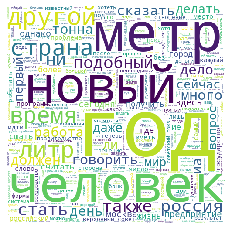

In [55]:
wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(df_base['lemmas_clean'].sum()))
plt.imshow(wc)
plt.axis("off")

(-0.5, 499.5, 499.5, -0.5)

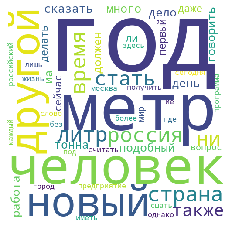

In [57]:
wc = wordcloud.WordCloud(background_color="white", max_words=50, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(df_base['lemmas_clean'].sum()))
plt.imshow(wc)
plt.axis("off")

In [58]:
df_base['category'] = [s == 'Communist' for s in df['type']]

In [62]:
def listToString(s):  
    str1 = " " 
    return (str1.join(s)) 

In [63]:
df_base['lemmas_clean_string'] = df_base['lemmas_clean'].apply(lambda x: listToString(x))

In [66]:
holdBackFraction = .2
train_data_df, test_data_df = lucem_illud_2020.trainTestSplit(df_base, holdBackFraction=holdBackFraction)

In [67]:
print(len(train_data_df))
print(len(test_data_df))

1044
260


In [68]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['lemmas_clean_string'])

In [69]:
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

In [70]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))

In [71]:
train_data_df['pca'] = [r for r in reduced_data]

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


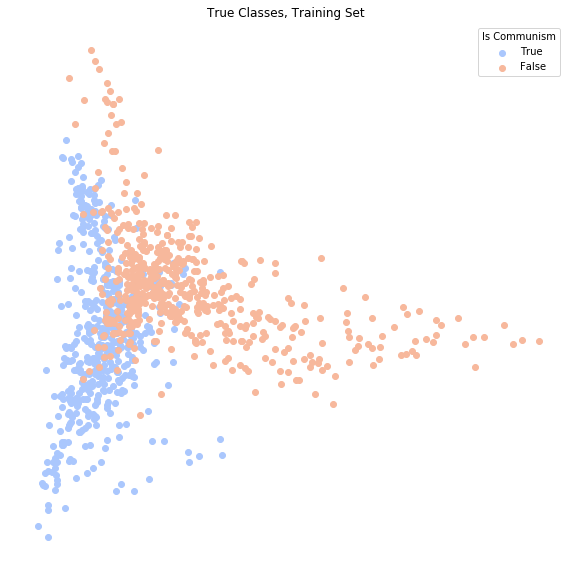

In [72]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

a = np.stack(train_data_df[train_data_df['category']]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")

a = np.stack(train_data_df[train_data_df['category'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")
    
ax.legend(loc = 'upper right', title = 'Is Communism')
plt.title('True Classes, Training Set')
plt.show()

In [74]:
naiveBayes = sklearn.naive_bayes.BernoulliNB()
naiveBayes.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [76]:
TFVects_test = TFVectorizer.transform(test_data_df['text'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

In [77]:
print("Training:")
print(naiveBayes.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))
print("Testing:")
print(naiveBayes.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

Training:
0.9798850574712644
Testing:
0.8615384615384616


In [79]:
test_data_df['nb_predict'] = naiveBayes.predict(np.stack(test_data_df['vect'], axis=0))
test_data_df['nb_predict_prob_true'] = naiveBayes.predict_proba(np.stack(test_data_df['vect'], axis=0))[:,0] #other is prop false

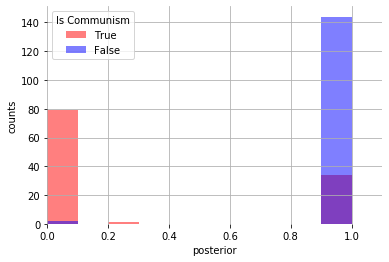

In [80]:
fig, ax = plt.subplots()
ax.grid(False)
ax.set_frame_on(False)
test_data_df[test_data_df['category'].eq(True)]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'True', color = 'red')
test_data_df[test_data_df['category'].eq(False)]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'False', color = 'blue')
ax.set_xlim((0,1.1))
ax.legend(title = "Is Communism")
ax.set_xlabel('posterior')
ax.set_ylabel('counts')
plt.show()

In [82]:
trueVals, falseVals = naiveBayes.feature_log_prob_

words_dict = {
    'Communism' : [],
    'Communism_log_prob' : [],
    'Democratic' : [],
    'Democratic_log_prob' : [],
}

for i, prob in sorted(enumerate(trueVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Communism'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Communism_log_prob'].append(prob)

for i, prob in sorted(enumerate(falseVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Democratic'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Democratic_log_prob'].append(prob)
    
pd.DataFrame(words_dict)

,Communism,Communism_log_prob,Democratic,Democratic_log_prob
0,цб,-1.718708,дружественный,-1.762603
1,екатеринбург,-1.750124,ор,-1.774164
2,индекс,-1.793610,взаимопонимание,-1.785860
3,акционер,-1.804783,жи,-1.785860
4,наличный,-1.816082,мышление,-1.785860
5,новгород,-1.816082,тель,-1.809670
6,приватизация,-1.816082,сонет,-1.821792
7,вексель,-1.839072,тия,-1.834062
8,корп,-1.839072,ча,-1.834062
9,фондовый,-1.874579,иго,-1.846484


In [84]:
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()

In [85]:
izvestiiaVects = ngCountVectorizer.fit_transform(df_base['lemmas_clean_string'])

In [87]:
izvestiiaTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(izvestiiaVects)
izvestiiaTF = izvestiiaTFTransformer.transform(izvestiiaVects)
print(izvestiiaTF.shape)

(1304, 494123)


In [89]:
izTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, norm='l2')
izvestiiaTFVects = izTFVectorizer.fit_transform(df_base['lemmas_clean_string'])

In [92]:
km3 = sklearn.cluster.KMeans(n_clusters=3, init='k-means++')

In [93]:
km3.fit(izvestiiaTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [95]:
km5 = sklearn.cluster.KMeans(n_clusters=5, init='k-means++')

In [96]:
km5.fit(izvestiiaTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [94]:
km7 = sklearn.cluster.KMeans(n_clusters=7, init='k-means++')

In [97]:
km7.fit(izvestiiaTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [98]:
# 3 clusters
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(df_base['category'], km3.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(df_base['category'], km3.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(df_base['category'], km3.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(df_base['category'], km3.labels_)))

Homogeneity: 0.391
Completeness: 0.249
V-measure: 0.304
Adjusted Rand Score: 0.285


In [99]:
# 5 clusters
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(df_base['category'], km5.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(df_base['category'], km5.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(df_base['category'], km5.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(df_base['category'], km5.labels_)))

Homogeneity: 0.263
Completeness: 0.120
V-measure: 0.164
Adjusted Rand Score: 0.104


In [100]:
# 7 clusters
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(df_base['category'], km7.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(df_base['category'], km7.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(df_base['category'], km7.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(df_base['category'], km7.labels_)))

Homogeneity: 0.524
Completeness: 0.191
V-measure: 0.280
Adjusted Rand Score: 0.184


In [101]:
#7
terms = izTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km7.cluster_centers_.argsort()[:, ::-1]
for i in range(7):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :20]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 депутат
 кпсс
 цк
 хозяйство
 иа
 верховный
 съезд
 труд
 коллектив
 трудовой
 продукция
 задача
 союзный
 пятилетка
 наука
 социальный
 товарищ
 перестройка
 научный
 совхоз


Cluster 1:
 банк
 компания
 доллар
 миллиард
 финансовый
 валютный
 акция
 биржа
 бумага
 бюджет
 кредит
 рост
 объем
 инвестиция
 курс
 валюта
 триллион
 банковский
 проект
 кредитный


Cluster 2:
 ул
 тело
 факс
 телефон
 компьютер
 склад
 оборудование
 банк
 товар
 ао
 выставка
 адрес
 поставка
 гарантия
 продажа
 предлагать
 обслуживание
 торговый
 компания
 автомобиль


Cluster 3:
 ядерный
 цк
 вооружение
 оружие
 кпсс
 военный
 сотрудничество
 иа
 американский
 переговоры
 делегация
 секретарь
 тасса
 визит
 оон
 безопасность
 социалистический
 война
 корр
 иностранный


Cluster 4:
 деньги
 суд
 доллар
 закон
 ребенок
 театр
 русский
 выборы
 военный
 бывший
 тело
 ельцин
 машина
 война
 факс
 писать
 александр
 сообщить
 жить
 рф


Cluster 5:
 иа
 ие
 ти
 ми
 ив
 ре
 де


In [102]:
df_base['kmeans_predictions_7'] = km7.labels_

In [104]:
export_json = df_base.to_json('izvestiia_kmeans_7.json')

In [105]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(izvestiiaTFVects.toarray())
reduced_data = pca.transform(izvestiiaTFVects.toarray())

In [106]:
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

In [107]:
colordict = {
    0: 'red',
    1: 'orange',
    2: 'yellow',
    3: 'green',
    4: 'blue',
    5: 'purple',
    6: 'black'
            }

colors = [colordict[c] for c in df_base['kmeans_predictions_7']]
print("The categories' colors are:\n{}".format(colordict.items()))

The categories' colors are:
dict_items([(0, 'red'), (1, 'orange'), (2, 'yellow'), (3, 'green'), (4, 'blue'), (5, 'purple'), (6, 'black')])


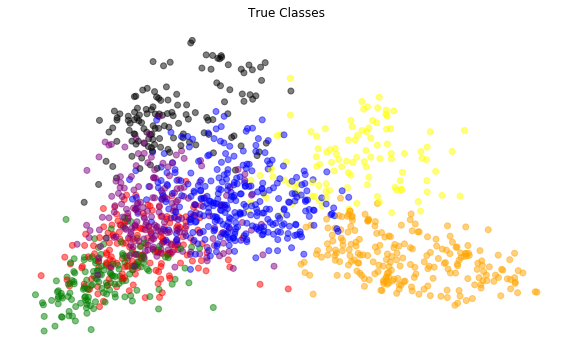

In [108]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

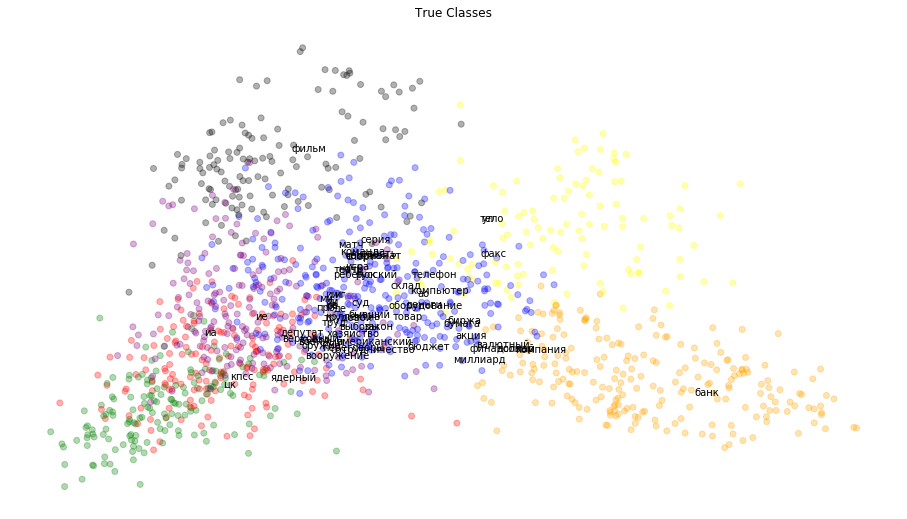

In [109]:
fig = plt.figure(figsize = (16,9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.3, label = colors)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

In [110]:
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


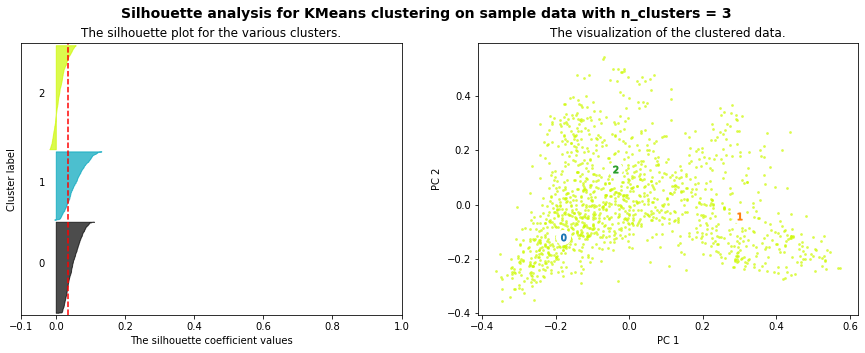

For n_clusters = 3, The average silhouette_score is : 0.036


In [111]:
X = izvestiiaTFVects.toarray()
plotSilhouette(3, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


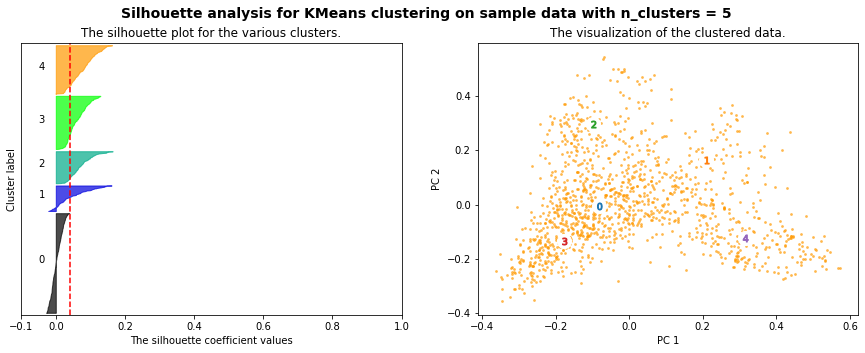

For n_clusters = 5, The average silhouette_score is : 0.041


In [112]:
X = izvestiiaTFVects.toarray()
plotSilhouette(5, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


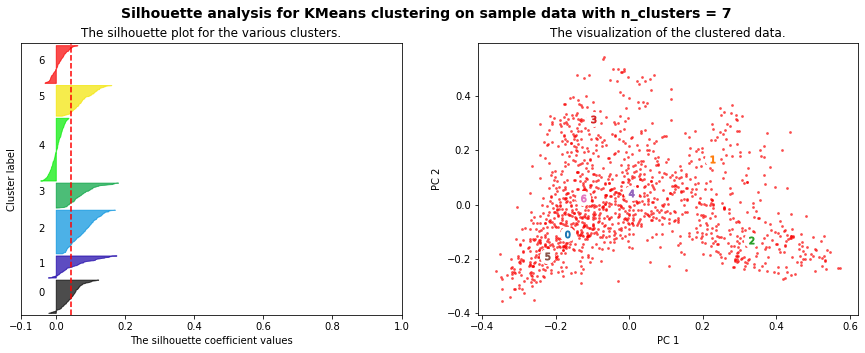

For n_clusters = 7, The average silhouette_score is : 0.043


In [113]:
X = izvestiiaTFVects.toarray()
plotSilhouette(7, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


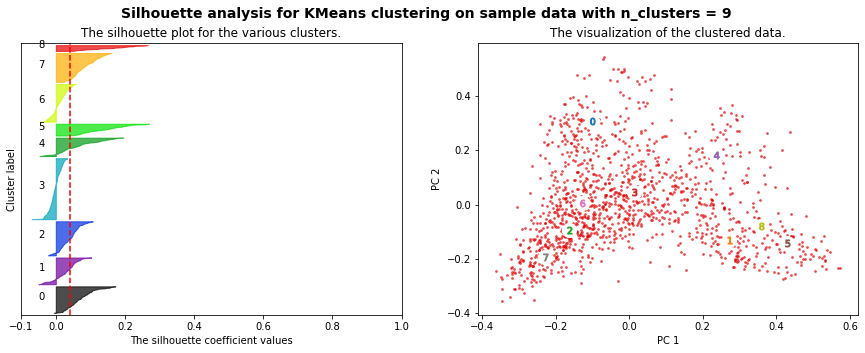

For n_clusters = 9, The average silhouette_score is : 0.041


In [151]:
X = izvestiiaTFVects.toarray()
plotSilhouette(9, X)